# LG 전자 주식 종목 예측하기
***

# STEP 1 : 시계열 데이터 준비
***

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# Time Series 생성

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/066570.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

**날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어있음.(실수형 데이터 및 정수형 데이터)**

In [28]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
        # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    
    dftest = adfuller(timeseries, autolag='AIC')  
    
       # adfuller 메서드가 리턴한 결과를 정리, 그리고 출력
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

ts = df['Close']

ts.head()

Date
2021-05-06    151500.0
2021-05-07    153000.0
2021-05-10    153500.0
2021-05-11    149000.0
2021-05-12    147000.0
Name: Close, dtype: float64

In [29]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()    # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()      # 이동표준편차 시계열

         # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화하기
        
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

**우리는 종가(Close)만 사용한다.**

# STEP 2: 각종 전처리 수행
***
* 결측치 처리
* 로그 변환

In [30]:
# 결측치 처리하기

ts = ts.interpolate(method='time')
ts[ts.isna()]        # Time Series에서 결측치가 있는 부분만 Series로 출력


Series([], Name: Close, dtype: float64)

Series 안의 데이터가 없으므로 결측치가 없다.

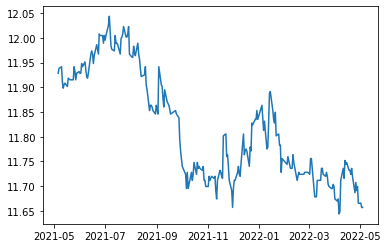

In [31]:
# 로그 변환하기

ts_log = np.log(ts)
plt.plot(ts_log)

In [32]:
augmented_dickey_fuller_test(ts)           # adfuller 메서드를 사용

Results of Dickey-Fuller Test:
Test Statistic                  -0.895745
p-value                          0.789371
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


In [33]:
augmented_dickey_fuller_test(ts_log)         # adfuller 메서드를 사용

Results of Dickey-Fuller Test:
Test Statistic                  -1.245765
p-value                          0.653606
#Lags Used                       1.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


p-value 값이 조금 떨어진 것을 확인 할 수 있다.

# STEP 3 : 시계열 안정성 분석
***
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

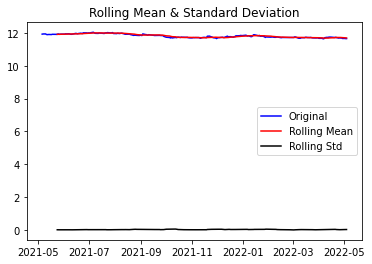

Results of Dickey-Fuller Test:
Test Statistic                  -1.245765
p-value                          0.653606
#Lags Used                       1.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


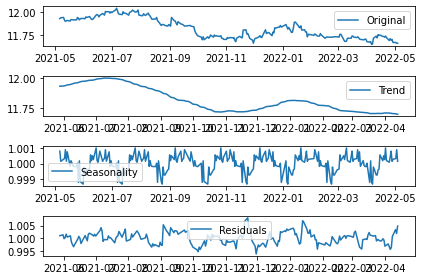

In [34]:
# 정성적 그래프 분석

plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test

augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [35]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.790305e+00
p-value                        4.889880e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


시계열 분해 (Time Series Decomposition) 작업을 통해서 p-value 값이 4.889880e-07 라는 아주 작은 값으로 바뀌었음. 

# STEP 4 : 학습, 테스트 데이터셋 생성
***
* 학습, 테스트 데이터셋 분리


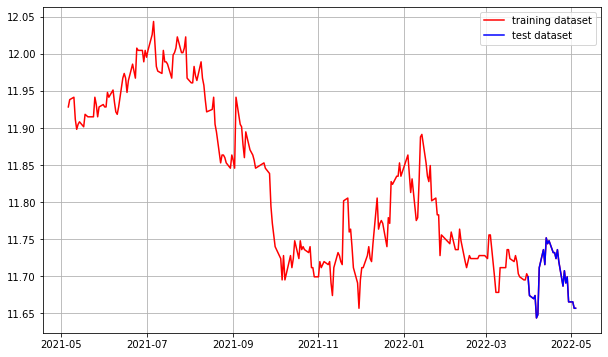

In [36]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [37]:
#데이터 셋의 형태 

print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)


Date
2021-05-06    11.928341
2021-05-07    11.938193
Name: Close, dtype: float64
(221,)
(25,)


# STEP 5 : 적정 ARIMA 모수 찾기
***
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

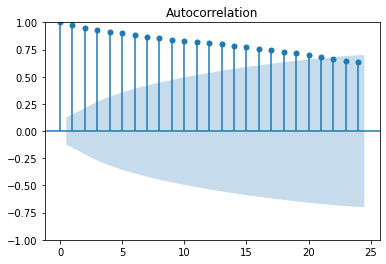

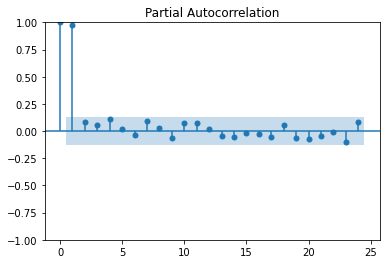

In [38]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF 그래프를 보면 점차적으로 감소하는 경향이 있고 q에 대해서는 적합한 값이 없는 것 같다.

PACF그래프를 볼때는 p= 1일때 적합하다.


Results of Dickey-Fuller Test:
Test Statistic                -1.751322e+01
p-value                        4.323976e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


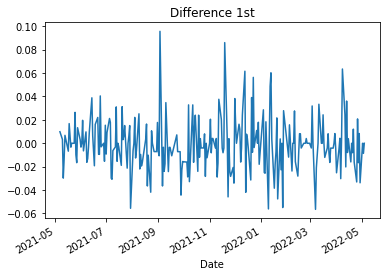

In [39]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.905150e+00
p-value                        4.085435e-12
#Lags Used                     1.300000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


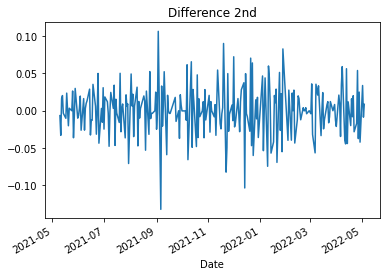

In [40]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분과 2차 차분의 p-value 값을 보면 2차 차분의 p-value 값이 더 낮다.
최적의 차분은 d=2 일때 이다.

# STEP 6 : ARIMA 모델 훈련과 테스트
***
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [41]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  221
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 524.951
Date:                Thu, 05 May 2022   AIC                          -1043.902
Time:                        14:07:09   BIC                          -1033.721
Sample:                             0   HQIC                         -1039.791
                                - 221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1251      0.067     -1.869      0.062      -0.256       0.006
ar.L2         -0.0652      0.064     -1.015      0.310      -0.191       0.061
sigma2         0.0005    3.3e-05     15.005      0.0

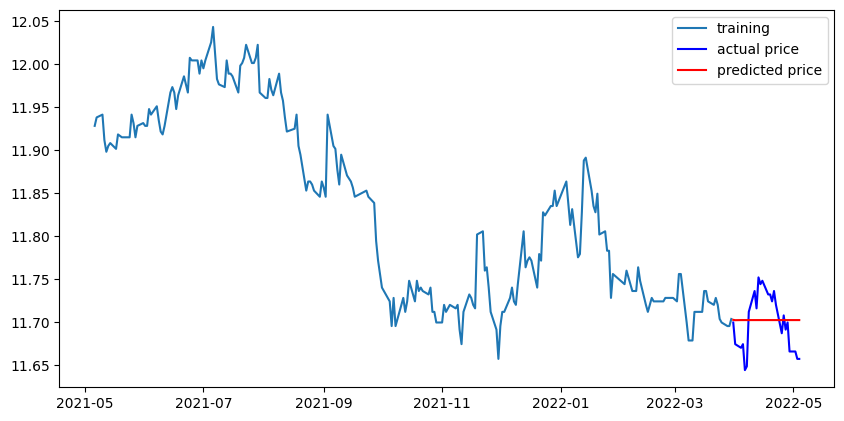

In [42]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  15934496.667694716
MAE:  3514.4026059546977
RMSE:  3991.803686016475
MAPE: 2.93%


결과적으로는 MAPE 오차율이 2.93%로 어느정도 예측을 잘 했다고 볼수 있다.


# 회고
***
시계열 데이터를 예측 하는 것은 사실 그리 간단한 작업은 아니라고 생각이 든다.
과거의 데이터에 대해서 판단을 하고 미래에 대해서 예측을 하는 것은 여러가지 오류를 범할수 있기 때문이다. 실제 데이터에서는 변수들이 많으므로 한가지 예측으로는 판단하기 어렵다고 생각한다. 그러나 신뢰할 수 있는 데이터가 쌓인다면 좀 더 좋은 예측을 할 수 있다